In [1]:
!pip3 install -e .. -U

Obtaining file:///Users/adam/Desktop/Capfolio/tensortrade
  Found existing installation: TensorTrade 0.1.0rc1
    Uninstalling TensorTrade-0.1.0rc1:
      Successfully uninstalled TensorTrade-0.1.0rc1
  Running setup.py develop for tensortrade


In [2]:
%matplotlib inline

import pandas as pd

from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines import PPO2

from tensortrade.rewards import SimpleProfit
from tensortrade.actions import DiscreteActions
from tensortrade.features.stationarity import FractionalDifference
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline

normalize = MinMaxNormalizer(inplace=True)
difference = FractionalDifference(difference_order=0.6,
                                  inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize, difference])

reward_scheme = SimpleProfit()
action_scheme = DiscreteActions(n_actions=20, instrument='ETH/BTC')

ohlcv_data = pd.read_csv('./data/Coinbase_BTCUSD_1h.csv', skiprows=1)
ohlcv_data = ohlcv_data[['open','high','low','close','volume']]

model = PPO2
policy = MlpLnLstmPolicy
params = { "learning_rate": 1e-5, 'nminibatches': 1 }

W1120 23:40:37.418528 4632464832 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/tensorforce/core/module.py:31: The name tf.enable_resource_variables is deprecated. Please use tf.compat.v1.enable_resource_variables instead.

W1120 23:40:37.439109 4632464832 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/tensorforce/core/optimizers/tf_optimizer.py:46: The name tf.train.AdadeltaOptimizer is deprecated. Please use tf.compat.v1.train.AdadeltaOptimizer instead.

W1120 23:40:37.439727 4632464832 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/tensorforce/core/optimizers/tf_optimizer.py:47: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.

W1120 23:40:37.440772 4632464832 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/tensorforce/core/optimizers/tf_optimizer.py:48: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train

In [3]:
from tensortrade.environments import TradingEnvironment
from tensortrade.strategies import StableBaselinesTradingStrategy
from tensortrade.exchanges.simulated import StochasticExchange

WINDOW_SIZE = 1

exchange = StochasticExchange(base_instrument='BTC',
                       timeframe='1h',
                       window_size=WINDOW_SIZE,
                       pretransform=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)

strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

performance = strategy.run(steps=1665)

performance[-5:]

Finished running strategy.
Total episodes: 1 (1665 timesteps).
Average reward: -23.144483907898547.


,step,balance,net_worth
1125,1657.0,940.254128,56984.785954
1126,1659.0,7.578389,51906.941999
1127,1661.0,23424.581711,46912.401199
1128,1662.0,28905.322178,45425.684835
1129,1664.0,487.096899,48317.545770


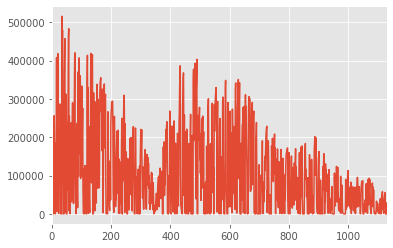

In [4]:
performance.balance.plot()

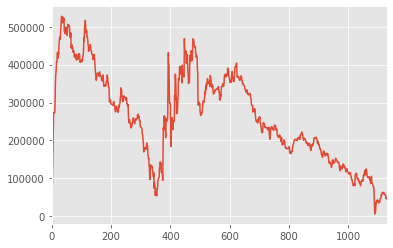

In [5]:
performance.net_worth.plot()

In [6]:
from tensortrade.environments import TradingEnvironment
from tensortrade.strategies import StableBaselinesTradingStrategy
from tensortrade.exchanges.simulated import SimulatedExchange

exchange = SimulatedExchange(base_instrument='USD',
                             data_frame=ohlcv_data,
                             price_column='close',
                             window_size=WINDOW_SIZE,
                             pretransform=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)

strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

performance = strategy.run(steps=1665)

performance[-5:]

Finished running strategy.
Total episodes: 0 (1665 timesteps).
Average reward: -1.675899743897855.


,step,balance,net_worth
1146,1659.0,296.390273,344.784065
1147,1660.0,308.453416,344.751611
1148,1661.0,326.594549,344.804803
1149,1662.0,339.988517,344.533228
1150,1663.0,344.538493,344.538493


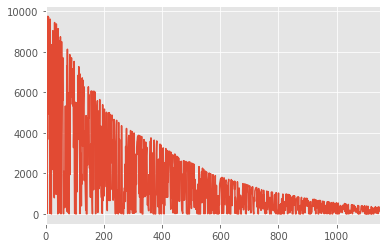

In [7]:
performance.balance.plot()

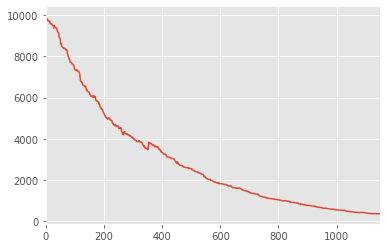

In [8]:
performance.net_worth.plot()

In [9]:
from tensortrade.environments import TradingEnvironment
from tensortrade.strategies import StableBaselinesTradingStrategy
from tensortrade.exchanges.simulated import StochasticExchange

WINDOW_SIZE = 20

exchange = StochasticExchange(base_instrument='BTC',
                       timeframe='1h',
                       window_size=WINDOW_SIZE,
                       pretransform=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)

strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

performance = strategy.run(steps=1665)

performance[-5:]

Finished running strategy.
Total episodes: 1 (1665 timesteps).
Average reward: -24.322984997376324.


,step,balance,net_worth
1125,1654.0,2.064825e+06,2.749255e+06
1126,1655.0,3.491522e+04,2.773496e+06
1127,1656.0,1.553641e+06,3.086042e+06
1128,1658.0,4.091426e+05,2.889702e+06
1129,1660.0,3.004304e+06,3.004304e+06


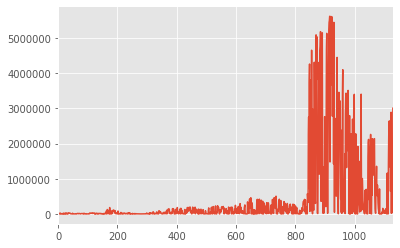

In [10]:
performance.balance.plot()

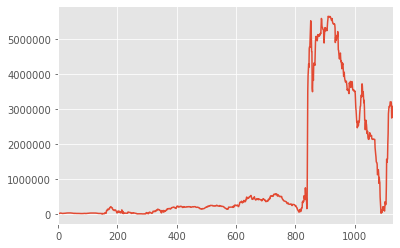

In [11]:
performance.net_worth.plot()

In [12]:
from tensortrade.environments import TradingEnvironment
from tensortrade.strategies import StableBaselinesTradingStrategy
from tensortrade.exchanges.simulated import SimulatedExchange

WINDOW_SIZE = 20

exchange = SimulatedExchange(base_instrument='USD',
                             data_frame=ohlcv_data,
                             price_column='close',
                             window_size=WINDOW_SIZE,
                             pretransform=True)

environment = TradingEnvironment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)

strategy = StableBaselinesTradingStrategy(environment=environment,
                                          model=model,
                                          policy=policy,
                                          model_kwargs=params)

performance = strategy.run(steps=1665)

performance[-5:]

Finished running strategy.
Total episodes: 0 (1665 timesteps).
Average reward: -1.6543994775803847.


,step,balance,net_worth
1128,1660.0,193.785260,417.242577
1129,1661.0,3.267517,417.425750
1130,1663.0,1.632218,418.407319
1131,1664.0,0.820897,417.387085
1132,1665.0,314.338189,419.158372


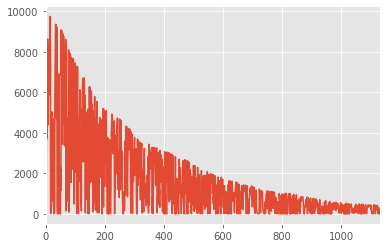

In [13]:
performance.balance.plot()

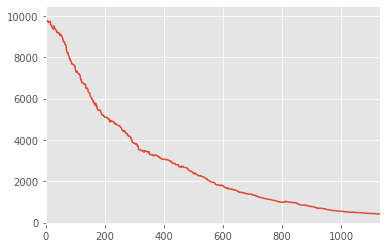

In [14]:
performance.net_worth.plot()

In [15]:
strategy.save_agent('agents/PPO_BTC_1h')